In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.optimize import brentq, least_squares
import sys

sys.path.append("..")

from analytical_option_formulae.option_types.vanilla_option import VanillaOption

plt.style.use("classic")

# 1. Data Preparation


In [2]:
df_spx = pd.read_csv("../data/SPX_options.csv")
df_spy = pd.read_csv("../data/SPY_options.csv")
df_rates = pd.read_csv("../data/zero_rates_20201201.csv")

S_SPX = 3662.45
S_SPY = 366.02

In [3]:
def process_rates_data(df):
    def convert_datetime(df):
        df["date"] = pd.to_datetime(df["date"], format="%Y%m%d")

    def convert_rates_to_decimal(df):
        df["rate_decimal"] = df["rate"] / 100

    def interpolate_rates(df):
        df = df.drop(["date"], axis=1)
        df.set_index("days", inplace=True)
        df_reindexed = df.reindex(np.arange(df.index.min(), df.index.max() + 1))
        df_reindexed = df_reindexed.interpolate(method="linear")
        return df_reindexed

    df = df.copy()
    convert_datetime(df)
    convert_rates_to_decimal(df)
    df = interpolate_rates(df)
    return df


def process_options_data(df):
    def convert_datetime(df):
        df["date"] = pd.to_datetime(df["date"], format="%Y%m%d")
        df["exdate"] = pd.to_datetime(df["exdate"], format="%Y%m%d")

    def compute_time_to_maturity(df):
        df["days_to_expiry"] = (df["exdate"] - df["date"]) / pd.Timedelta(days=1)
        df["years_to_expiry"] = df["days_to_expiry"] / 365

    def compute_mid_price(df):
        df["mid_price"] = 0.5 * (df["best_bid"] + df["best_offer"])

    def convert_strike_price(df):
        df["strike_price"] = df["strike_price"] / 1000

    def convert_flag_to_options_type(df):
        df["options_type"] = df["cp_flag"].map(lambda x: "call" if x == "C" else "put")

    df = df.copy()
    convert_datetime(df)
    compute_time_to_maturity(df)
    compute_mid_price(df)
    convert_strike_price(df)
    convert_flag_to_options_type(df)
    return df


df_spx_processed = process_options_data(df_spx)
df_spy_processed = process_options_data(df_spy)
df_rates_processed = process_rates_data(df_rates)

# 2. Common Models and Functions


In [4]:
vanilla_option = VanillaOption()


def implied_volatility(
    S: float, K: float, r: float, price: float, T: float, options_type: str
) -> float:
    try:
        bs_model = lambda x: vanilla_option.black_scholes_model(S, K, r, x, T)
        if options_type.lower() == "call":
            implied_vol = brentq(
                lambda x: price - bs_model(x).calculate_call_price(), 1e-12, 10.0
            )
        elif options_type.lower() == "put":
            implied_vol = brentq(
                lambda x: price - bs_model(x).calculate_put_price(), 1e-12, 10.0
            )
        else:
            raise NameError("Payoff type not recognized")
    except Exception:
        implied_vol = np.nan

    return implied_vol

# 3. Implied Volatility Computation


In [5]:
def compute_implied_volatility_for(df_options, current_price):
    S = current_price
    days_to_expiry_arr = df_options["days_to_expiry"].unique()
    df_volatility_by_dte_dict = {}
    for day_to_expire in days_to_expiry_arr:
        df_filtered = df_options[
            df_options["days_to_expiry"] == day_to_expire
        ].reset_index(drop=True)
        rates = df_rates_processed.loc[int(df_filtered["days_to_expiry"][0])][
            "rate_decimal"
        ]
        df_filtered["implied_vol"] = df_filtered.apply(
            lambda x: implied_volatility(
                S,
                x["strike_price"],
                rates,
                x["mid_price"],
                x["years_to_expiry"],
                x["options_type"],
            ),
            axis=1,
        )
        df_filtered.dropna(inplace=True)

        df_call = df_filtered[df_filtered["options_type"] == "call"]
        df_put = df_filtered[df_filtered["options_type"] == "put"]
        strikes = df_put["strike_price"].values
        implied_vols = []
        options_type = []
        for K in strikes:
            if S < K:
                options_type.append("call")
                implied_vols.append(
                    df_call[df_call["strike_price"] == K]["implied_vol"].values[0]
                )
            else:
                options_type.append("put")
                implied_vols.append(
                    df_put[df_put["strike_price"] == K]["implied_vol"].values[0]
                )
        df_implied_vols = pd.DataFrame(
            {
                "strike": strikes,
                "impliedvol": implied_vols,
                "options_type": options_type,
            }
        )
        df_volatility_by_dte_dict[str(int(day_to_expire))] = df_implied_vols
    return df_volatility_by_dte_dict


implied_vol_dict_spx = compute_implied_volatility_for(df_spx_processed, S_SPX)
implied_vol_dict_spy = compute_implied_volatility_for(df_spy_processed, S_SPY)

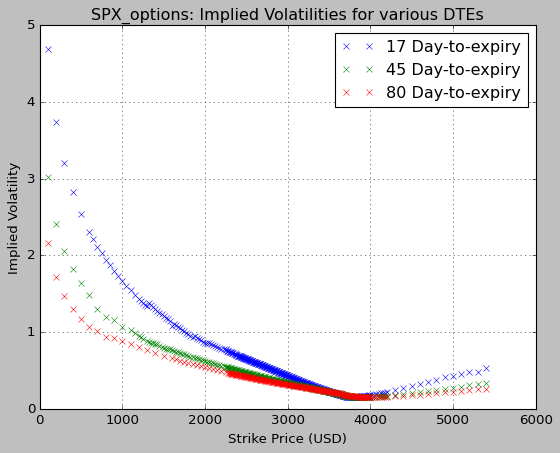

In [6]:
plt.title("SPX_options: Implied Volatilities for various DTEs")
for day_to_expiry, df_vol in implied_vol_dict_spx.items():
    plt.plot(
        df_vol["strike"],
        df_vol["impliedvol"],
        "x",
        label="{} Day-to-expiry".format(day_to_expiry),
    )

plt.grid()
plt.xlabel("Strike Price (USD)")
plt.ylabel("Implied Volatility")
plt.legend()
plt.savefig("Part_2_market_vol_SPX_options.png")

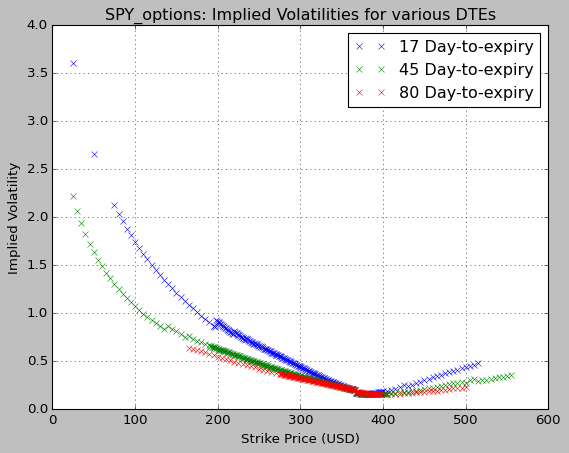

In [7]:
plt.title("SPY_options: Implied Volatilities for various DTEs")
for day_to_expiry, df_vol in implied_vol_dict_spy.items():
    plt.plot(
        df_vol["strike"],
        df_vol["impliedvol"],
        "x",
        label="{} Day-to-expiry".format(day_to_expiry),
    )

plt.grid()
plt.xlabel("Strike Price (USD)")
plt.ylabel("Implied Volatility")
plt.legend()
plt.savefig("Part_2_market_vol_SPY_options.png")

# 4. Displaced-Diffusion Model Calibration


# 4.1 Displaced-Diffusion Model


In [8]:
def calculate_DD_vol_err(x, strikes, vols, S, r, sigma, T, options_type):
    err = 0.0
    for i, vol in enumerate(vols):
        if options_type[i] == "call":
            price = vanilla_option.displaced_diffusion_model(
                S, strikes[i], r, sigma, T, x[0]
            ).calculate_call_price()
        else:
            price = vanilla_option.displaced_diffusion_model(
                S, strikes[i], r, sigma, T, x[0]
            ).calculate_put_price()
        implied_vol = implied_volatility(S, strikes[i], r, price, T, options_type[i])
        err += (vol - implied_vol) ** 2
    return err

## 4.2 European Options (SPX)


In [9]:
DD_params_by_dte_dict = {}

for day_to_expiry, df_vol in implied_vol_dict_spx.items():
    rates = df_rates_processed.loc[int(day_to_expiry)]["rate_decimal"]
    T = float(day_to_expiry) / 365
    S = S_SPX
    sigma = np.interp(S, df_vol["strike"], df_vol["impliedvol"])

    initial_guess = [0.96]  # beta
    res = least_squares(
        lambda x: calculate_DD_vol_err(
            x,
            df_vol["strike"],
            df_vol["impliedvol"],
            S,
            rates,
            sigma,
            T,
            df_vol["options_type"],
        ),
        initial_guess,
        bounds=(0, 1),
    )
    DD_params_by_dte_dict[day_to_expiry] = {"sigma": sigma, "beta": res.x[0]}
DD_params_by_dte_dict

{'17': {'sigma': 0.17448532472572187, 'beta': 1.4951483926899903e-07},
 '45': {'sigma': 0.1849096526276905, 'beta': 4.6911762064129315e-11},
 '80': {'sigma': 0.19374721854522414, 'beta': 1.4023836103986437e-06}}

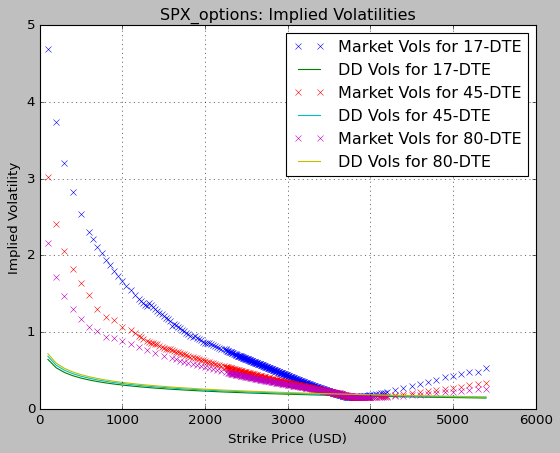

In [10]:
plt.title("SPX_options: Implied Volatilities")

for day_to_expiry, df_vol in implied_vol_dict_spx.items():
    rates = df_rates_processed.loc[int(day_to_expiry)]["rate_decimal"]
    T = float(day_to_expiry) / 365
    params = DD_params_by_dte_dict[day_to_expiry]
    beta = params["beta"]
    sigma = params["sigma"]

    ddvols = []
    for i, K in enumerate(df_vol["strike"]):
        option_type = df_vol["options_type"][i]
        if option_type == "call":
            price = vanilla_option.displaced_diffusion_model(
                S, K, rates, sigma, T, beta
            ).calculate_call_price()
        else:
            price = vanilla_option.displaced_diffusion_model(
                S, K, rates, sigma, T, beta
            ).calculate_put_price()
        implied_vol = implied_volatility(S, K, rates, price, T, option_type)
        ddvols.append(implied_vol)

    plt.plot(df_vol["strike"], df_vol["impliedvol"], "x", label="Market Vols for {}-DTE".format(day_to_expiry))
    plt.plot(df_vol["strike"], ddvols, label="DD Vols for {}-DTE".format(day_to_expiry))

plt.grid()
plt.xlabel("Strike Price (USD)")
plt.ylabel("Implied Volatility")
plt.legend()
plt.savefig(f"Part_2_DD_vols_SPX_options.png")
plt.show()

## 4.2 American Options (SPY)


In [11]:
DD_params_by_dte_dict = {}

for day_to_expiry, df_vol in implied_vol_dict_spy.items():
    rates = df_rates_processed.loc[int(day_to_expiry)]["rate_decimal"]
    T = float(day_to_expiry) / 365
    S = S_SPY
    sigma = np.interp(S, df_vol["strike"], df_vol["impliedvol"])

    initial_guess = [0.96]  # beta
    res = least_squares(
        lambda x: calculate_DD_vol_err(
            x,
            df_vol["strike"],
            df_vol["impliedvol"],
            S,
            rates,
            sigma,
            T,
            df_vol["options_type"],
        ),
        initial_guess,
        bounds=(0, 1),
    )
    DD_params_by_dte_dict[day_to_expiry] = {"sigma": sigma, "beta": res.x[0]}
DD_params_by_dte_dict

{'17': {'sigma': 0.200905534391913, 'beta': 2.3262481169082174e-06},
 '45': {'sigma': 0.1972176434869465, 'beta': 7.598549430030459e-07},
 '80': {'sigma': 0.2002402677797878, 'beta': 2.412466224433791e-07}}

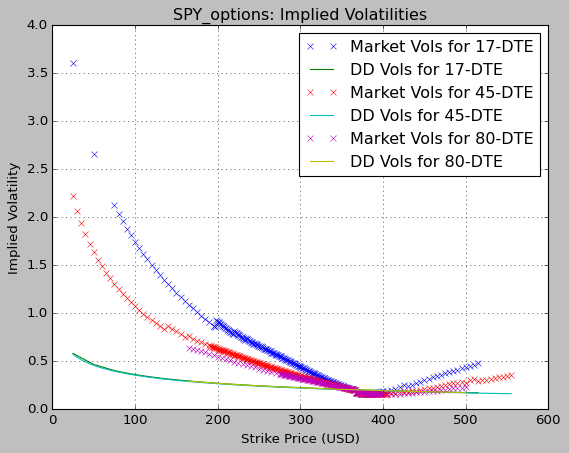

In [12]:
plt.title("SPY_options: Implied Volatilities")
for day_to_expiry, df_vol in implied_vol_dict_spy.items():
    rates = df_rates_processed.loc[int(day_to_expiry)]["rate_decimal"]
    T = float(day_to_expiry) / 365
    params = DD_params_by_dte_dict[day_to_expiry]
    beta = params["beta"]
    sigma = params["sigma"]

    ddvols = []
    for i, K in enumerate(df_vol["strike"]):
        option_type = df_vol["options_type"][i]
        if option_type == "call":
            price = vanilla_option.displaced_diffusion_model(
                S, K, rates, sigma, T, beta
            ).calculate_call_price()
        else:
            price = vanilla_option.displaced_diffusion_model(
                S, K, rates, sigma, T, beta
            ).calculate_put_price()
        implied_vol = implied_volatility(S, K, rates, price, T, option_type)
        ddvols.append(implied_vol)
    plt.plot(df_vol["strike"], df_vol["impliedvol"], "x", label="Market Vols for {}-DTE".format(day_to_expiry))
    plt.plot(df_vol["strike"], ddvols, label="DD Vols for {}-DTE".format(day_to_expiry))

plt.grid()
plt.xlabel("Strike Price (USD)")
plt.ylabel("Implied Volatility")
plt.legend()
plt.savefig(f"Part_2_DD_vols_SPY_options.png")
plt.show()

# 5. SABR Model Calibration


# 5.1 SABR Model


In [13]:
def SABR_model(F, K, T, alpha, beta, rho, nu):
    X = K
    # if K is at-the-money-forward
    if abs(F - K) < 1e-12:
        numer1 = (((1 - beta) ** 2) / 24) * alpha * alpha / (F ** (2 - 2 * beta))
        numer2 = 0.25 * rho * beta * nu * alpha / (F ** (1 - beta))
        numer3 = ((2 - 3 * rho * rho) / 24) * nu * nu
        VolAtm = alpha * (1 + (numer1 + numer2 + numer3) * T) / (F ** (1 - beta))
        sabrsigma = VolAtm
    else:
        z = (nu / alpha) * ((F * X) ** (0.5 * (1 - beta))) * np.log(F / X)
        zhi = np.log((((1 - 2 * rho * z + z * z) ** 0.5) + z - rho) / (1 - rho))
        numer1 = (((1 - beta) ** 2) / 24) * ((alpha * alpha) / ((F * X) ** (1 - beta)))
        numer2 = 0.25 * rho * beta * nu * alpha / ((F * X) ** ((1 - beta) / 2))
        numer3 = ((2 - 3 * rho * rho) / 24) * nu * nu
        numer = alpha * (1 + (numer1 + numer2 + numer3) * T) * z
        denom1 = ((1 - beta) ** 2 / 24) * (np.log(F / X)) ** 2
        denom2 = (((1 - beta) ** 4) / 1920) * ((np.log(F / X)) ** 4)
        denom = ((F * X) ** ((1 - beta) / 2)) * (1 + denom1 + denom2) * zhi
        sabrsigma = numer / denom

    return sabrsigma


def calculate_SABR_vol_err(x, strikes, vols, F, T, beta):
    err = 0.0
    for i, vol in enumerate(vols):
        err += (vol - SABR_model(F, strikes[i], T, x[0], beta, x[1], x[2])) ** 2
    return err

## 5.2 European Options (SPX)


In [14]:
beta = 0.7
SABR_params_by_dte_dict = {}

for day_to_expiry, df_vol in implied_vol_dict_spx.items():
    rates = df_rates_processed.loc[int(day_to_expiry)]["rate_decimal"]
    T = float(day_to_expiry) / 365
    F = S_SPX * np.exp(rates * T)

    initial_guess = [0.02, 0.2, 0.1]  # alpha, rho, nu
    res = least_squares(
        lambda x: calculate_SABR_vol_err(
            x, df_vol["strike"], df_vol["impliedvol"], F, T, beta
        ),
        initial_guess,
    )
    SABR_params_by_dte_dict[day_to_expiry] = {
        "F": F,
        "alpha": res.x[0],
        "beta": beta,
        "rho": res.x[1],
        "nu": res.x[2],
    }
SABR_params_by_dte_dict

/var/folders/f9/d_pgcy790lqf4pmtmqr5nns40000gn/T/ipykernel_5668/1652073992.py:12: RuntimeWarning: invalid value encountered in scalar power
  zhi = np.log((((1 - 2 * rho * z + z * z) ** 0.5) + z - rho) / (1 - rho))
/var/folders/f9/d_pgcy790lqf4pmtmqr5nns40000gn/T/ipykernel_5668/1652073992.py:12: RuntimeWarning: invalid value encountered in log
  zhi = np.log((((1 - 2 * rho * z + z * z) ** 0.5) + z - rho) / (1 - rho))


{'17': {'F': 3662.664084743022,
  'alpha': 1.2122899844013166,
  'beta': 0.7,
  'rho': -0.3009003071282838,
  'nu': 5.459761403316039},
 '45': {'F': 3663.3762493669747,
  'alpha': 1.8165044370781172,
  'beta': 0.7,
  'rho': -0.4043017672449347,
  'nu': 2.790158312103804},
 '80': {'F': 3664.221472703759,
  'alpha': 2.1401326057931307,
  'beta': 0.7,
  'rho': -0.5749338828597951,
  'nu': 1.8417469767440264}}

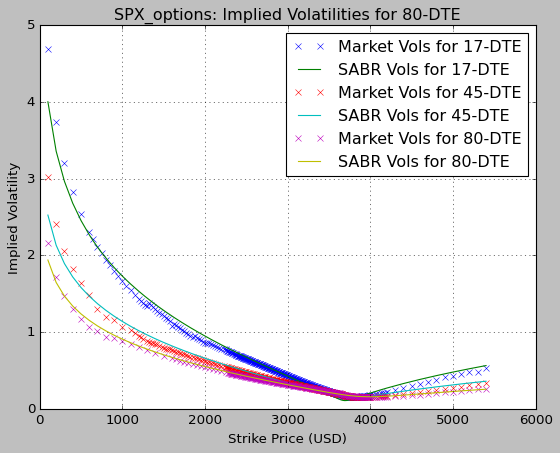

In [15]:
plt.title("SPX_options: Implied Volatilities for {}-DTE".format(day_to_expiry))
for day_to_expiry, df_vol in implied_vol_dict_spx.items():
    rates = df_rates_processed.loc[int(day_to_expiry)]["rate_decimal"]
    T = float(day_to_expiry) / 365
    F = S_SPX * np.exp(rates * T)
    params = SABR_params_by_dte_dict[day_to_expiry]

    sabrvols = []
    for K in df_vol["strike"]:
        sabrvols.append(
            SABR_model(F, K, T, params["alpha"], beta, params["rho"], params["nu"])
        )
    plt.plot(df_vol["strike"], df_vol["impliedvol"], "x", label="Market Vols for {}-DTE".format(day_to_expiry))
    plt.plot(df_vol["strike"], sabrvols, label="SABR Vols for {}-DTE".format(day_to_expiry))

plt.grid()
plt.xlabel("Strike Price (USD)")
plt.ylabel("Implied Volatility")
plt.legend()
plt.savefig(f"Part_2_SABR_vols_SPX_options.png")
plt.show()

## 5.3 American Options (SPY)


In [16]:
beta = 0.7
SABR_params_by_dte_dict = {}

for day_to_expiry, df_vol in implied_vol_dict_spy.items():
    rates = df_rates_processed.loc[int(day_to_expiry)]["rate_decimal"]
    T = float(day_to_expiry) / 365
    F = S_SPY * np.exp(rates * T)

    initial_guess = [0.02, 0.2, 0.1]  # alpha, rho, nu
    res = least_squares(
        lambda x: calculate_SABR_vol_err(
            x, df_vol["strike"], df_vol["impliedvol"], F, T, beta
        ),
        initial_guess,
    )
    SABR_params_by_dte_dict[day_to_expiry] = {
        "F": F,
        "alpha": res.x[0],
        "beta": beta,
        "rho": res.x[1],
        "nu": res.x[2],
    }
SABR_params_by_dte_dict

/var/folders/f9/d_pgcy790lqf4pmtmqr5nns40000gn/T/ipykernel_5668/1652073992.py:12: RuntimeWarning: invalid value encountered in scalar power
  zhi = np.log((((1 - 2 * rho * z + z * z) ** 0.5) + z - rho) / (1 - rho))


{'17': {'F': 366.0413953221589,
  'alpha': 0.665402204950474,
  'beta': 0.7,
  'rho': -0.41189986681675406,
  'nu': 5.249981393868968},
 '45': {'F': 366.11256803322914,
  'alpha': 0.9081326337814014,
  'beta': 0.7,
  'rho': -0.4887794457550238,
  'nu': 2.7285163417661487},
 '80': {'F': 366.1970384412155,
  'alpha': 1.1209243552965586,
  'beta': 0.7,
  'rho': -0.6329391713077503,
  'nu': 1.7422247729367686}}

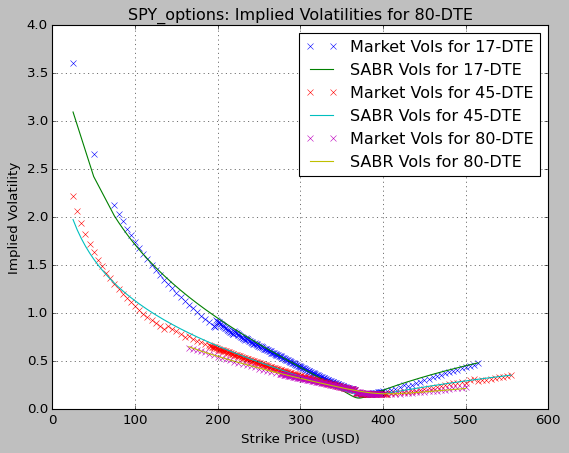

In [17]:
plt.title("SPY_options: Implied Volatilities for {}-DTE".format(day_to_expiry))
for day_to_expiry, df_vol in implied_vol_dict_spy.items():
    rates = df_rates_processed.loc[int(day_to_expiry)]["rate_decimal"]
    T = float(day_to_expiry) / 365
    F = S_SPY * np.exp(rates * T)
    params = SABR_params_by_dte_dict[day_to_expiry]

    sabrvols = []
    for K in df_vol["strike"]:
        sabrvols.append(
            SABR_model(F, K, T, params["alpha"], beta, params["rho"], params["nu"])
        )
    plt.plot(df_vol["strike"], df_vol["impliedvol"], "x", label="Market Vols for {}-DTE".format(day_to_expiry))
    plt.plot(df_vol["strike"], sabrvols, label="SABR Vols for {}-DTE".format(day_to_expiry))

plt.grid()
plt.xlabel("Strike Price (USD)")
plt.ylabel("Implied Volatility")
plt.legend()
plt.savefig(f"Part_2_SABR_vols_SPY_options.png")
plt.show()